# Análisis Predictivo Global COVID-19

## Objetivo
Análisis de la propagación del COVID-19 utilizando datos históricos procesados que incluyen:
- Casos y muertes diarias
- Medias móviles de 7 días
- Tasas de crecimiento
- Métricas por millón de habitantes

### Librerías necesarias


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


### 1. Carga y Exploración de Datos
Los datos provienen de la API disease.sh y han sido preprocesados para incluir:
- Métricas diarias
- Promedios móviles
- Tasas de crecimiento


In [2]:
# Carga del archivo parquet
url = "https://github.com/AntaresAnton/Prueba-02-Mineria-datos/raw/main/data/raw/covid_historical_data.parquet"
df = pd.read_parquet(url)

print("Estructura del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())


Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1143 non-null   datetime64[ns]
 1   cases               1143 non-null   int64         
 2   deaths              1143 non-null   int64         
 3   recovered           1143 non-null   int64         
 4   new_cases           1142 non-null   float64       
 5   new_deaths          1142 non-null   float64       
 6   growth_rate         1142 non-null   float64       
 7   cases_ma7           1136 non-null   float64       
 8   deaths_ma7          1136 non-null   float64       
 9   cases_per_million   1143 non-null   float64       
 10  deaths_per_million  1143 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 98.4 KB
None

Estadísticas descriptivas:
                      date         cas

### 2. Análisis de Tendencias Temporales
Visualización de la evolución temporal de casos y muertes


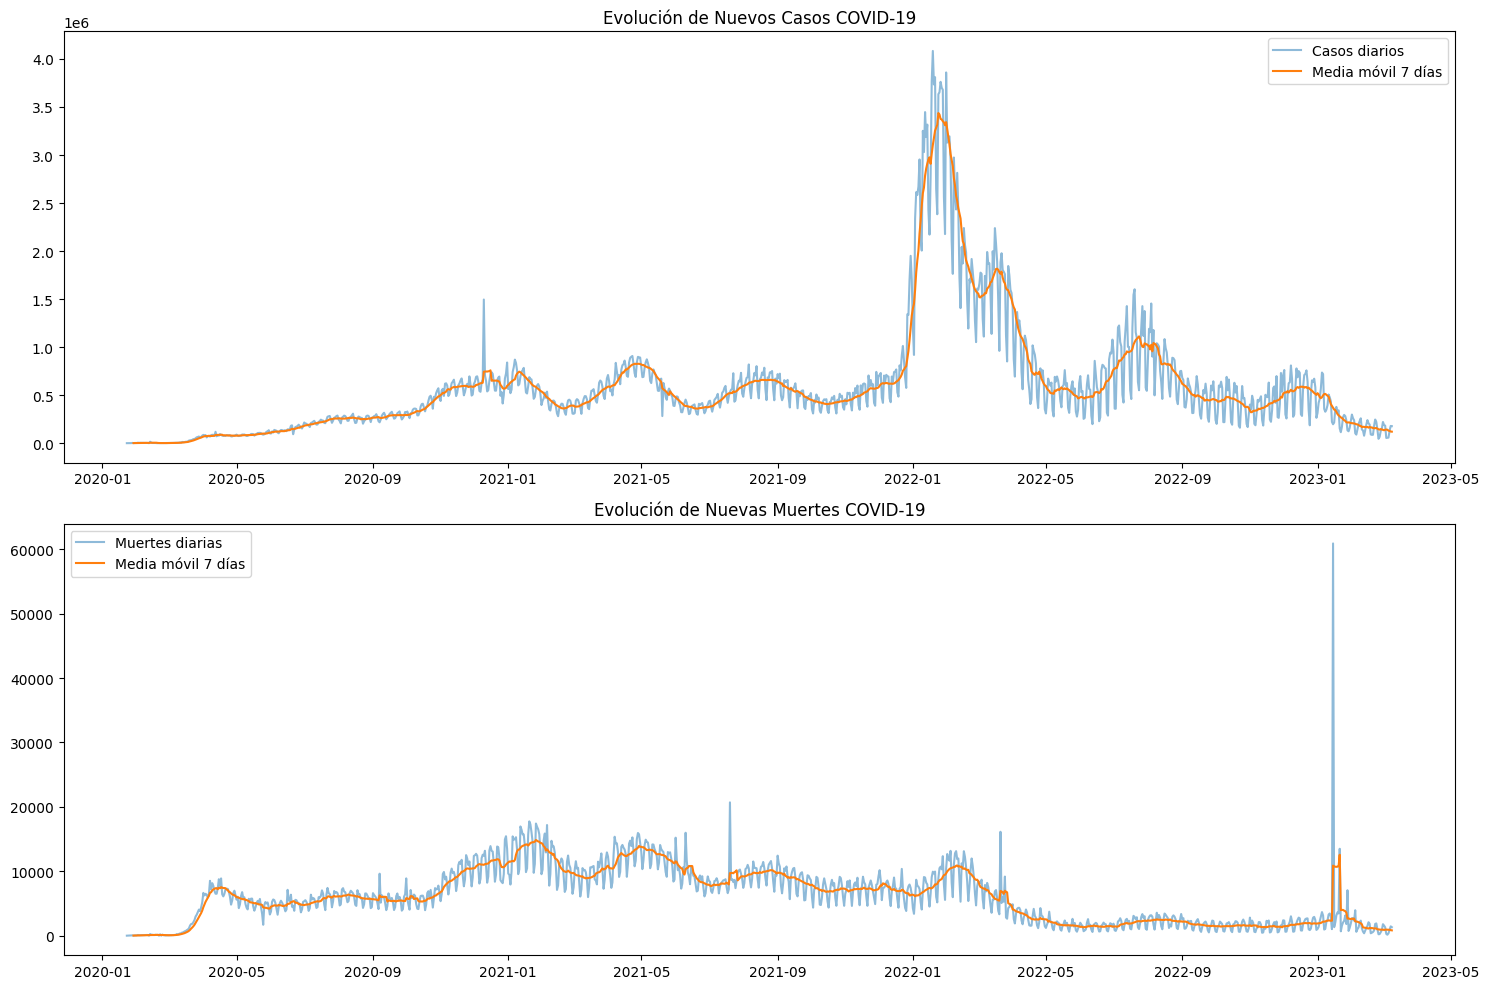


Estadísticas de tendencias:
Media de nuevos casos diarios: 592442.7250437828
Media de nuevas muertes diarias: 6026.081436077058


In [3]:
# Evolución temporal de casos y muertes
plt.figure(figsize=(15, 10))

# Subplot 1: Nuevos casos y media móvil
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['new_cases'], alpha=0.5, label='Casos diarios')
plt.plot(df['date'], df['cases_ma7'], label='Media móvil 7 días')
plt.title('Evolución de Nuevos Casos COVID-19')
plt.legend()

# Subplot 2: Nuevas muertes y media móvil
plt.subplot(2, 1, 2)
plt.plot(df['date'], df['new_deaths'], alpha=0.5, label='Muertes diarias')
plt.plot(df['date'], df['deaths_ma7'], label='Media móvil 7 días')
plt.title('Evolución de Nuevas Muertes COVID-19')
plt.legend()

plt.tight_layout()
plt.show()

# Estadísticas de tendencias
print("\nEstadísticas de tendencias:")
print("Media de nuevos casos diarios:", df['new_cases'].mean())
print("Media de nuevas muertes diarias:", df['new_deaths'].mean())


### 3. Análisis de Tasas de Crecimiento y Métricas por Millón


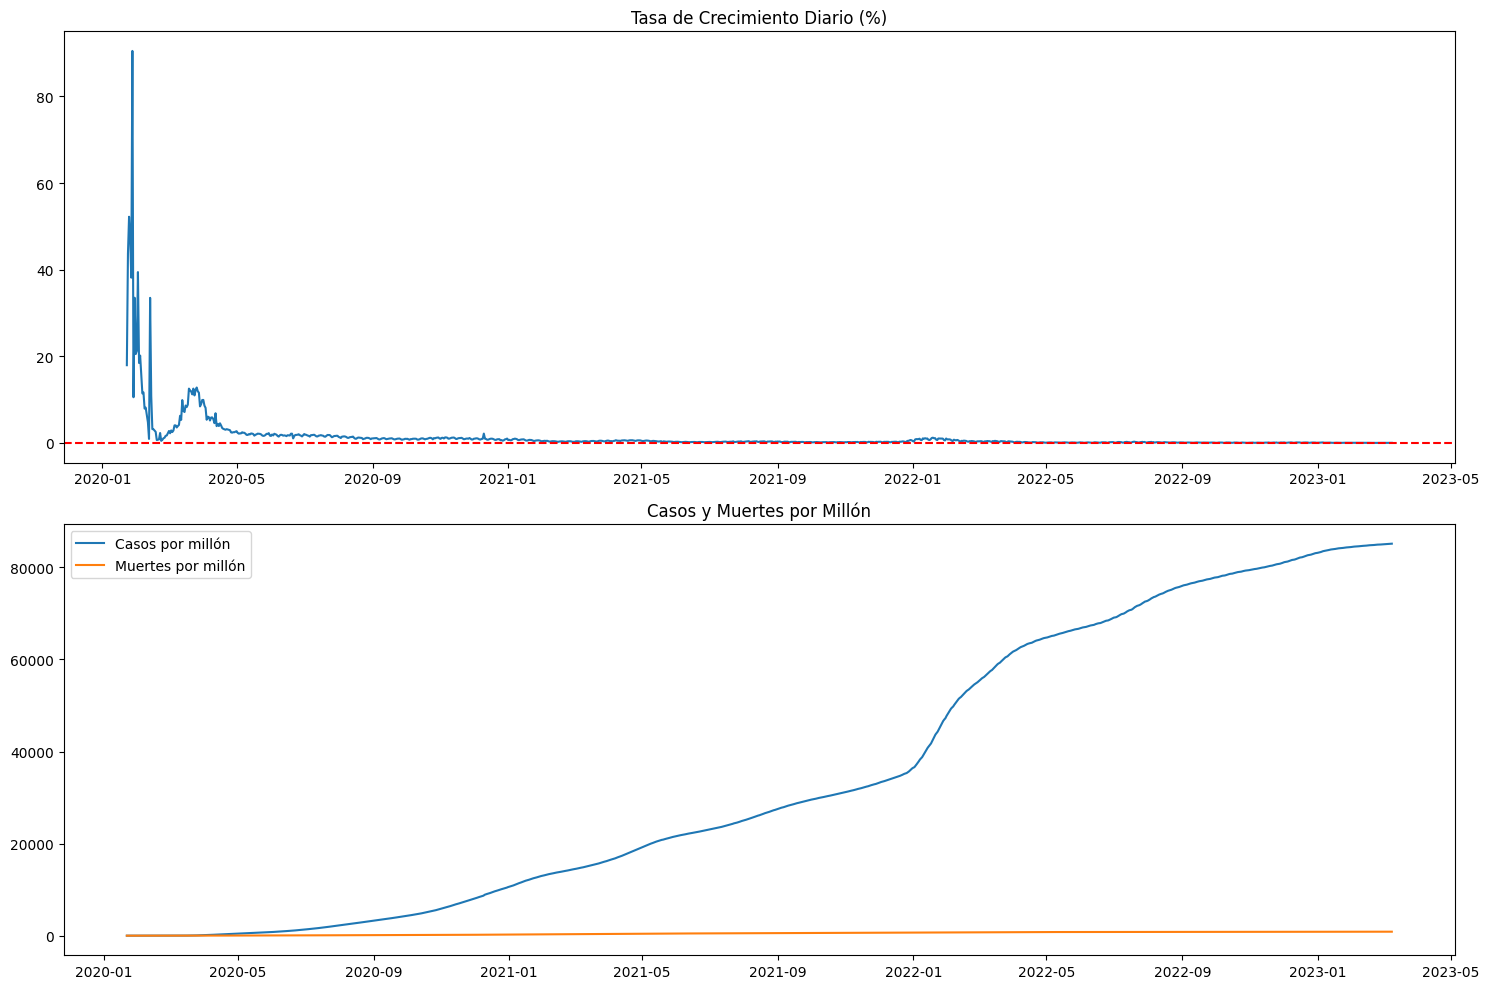


Estadísticas de crecimiento:
count    1142.000000
mean        1.317815
std         4.672011
min         0.006734
25%         0.142127
50%         0.330786
75%         0.980733
max        90.508706
Name: growth_rate, dtype: float64


In [4]:
plt.figure(figsize=(15, 10))

# Subplot 1: Tasa de crecimiento
plt.subplot(2, 1, 1)
plt.plot(df['date'], df['growth_rate'])
plt.title('Tasa de Crecimiento Diario (%)')
plt.axhline(y=0, color='r', linestyle='--')

# Subplot 2: Métricas por millón
plt.subplot(2, 1, 2)
plt.plot(df['date'], df['cases_per_million'], label='Casos por millón')
plt.plot(df['date'], df['deaths_per_million'], label='Muertes por millón')
plt.title('Casos y Muertes por Millón')
plt.legend()

plt.tight_layout()
plt.show()

print("\nEstadísticas de crecimiento:")
print(df['growth_rate'].describe())


### 4. Modelado Predictivo
Predicción de nuevos casos utilizando características históricas


In [5]:
# Selección de características
features = ['cases_ma7', 'deaths_ma7', 'growth_rate', 
           'cases_per_million', 'deaths_per_million']
X = df[features]
y = df['new_cases']

# División y escalado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# Limpieza de datos antes del modelado
# Eliminamos los valores NaN tanto de las características como de la variable objetivo
df_clean = df.dropna(subset=['new_cases'] + features)

# Selección de características
X = df_clean[features]
y = df_clean['new_cases']

# División y escalado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementación de modelos
models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(max_depth=6, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }


ValueError: Input y contains NaN.

### 5. Visualización de Resultados del Modelado


In [ ]:
# Comparación de modelos
plt.figure(figsize=(12, 6))
metrics_df = pd.DataFrame(results).T
metrics_df[['MAE', 'RMSE']].plot(kind='bar')
plt.title('Comparación de Métricas por Modelo')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Importancia de características
rf_model = models['Random Forest']
importances = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature')
plt.title('Importancia de Variables')
plt.tight_layout()
plt.show()


### 6. Conclusiones y Hallazgos Principales


In [ ]:
print("\nResultados del Modelado:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")

print("\nHallazgos Principales:")
print("1. Media móvil de casos (7 días):", df['cases_ma7'].mean())
print("2. Tasa de crecimiento promedio:", df['growth_rate'].mean())
print("3. Mejor modelo:", max(results.items(), key=lambda x: x[1]['R2'])[0])
print("4. Variable más importante:", importances.iloc[0]['feature'])
